## Import packages

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import glob


#global data
global left_fit
global right_fit
global right_curverad
global left_curverad
global prev_left
global prev_right
global prev_prev_right
global prev_prev_left
global first_time

left_fit=None
right_fit=None
right_curverad=0
left_curverad =0   
first_time=1

## Camera calibration

### extract object points and image points for camera calibration

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### calibrate, calculate distortion coefficients, and test undistortion on an image

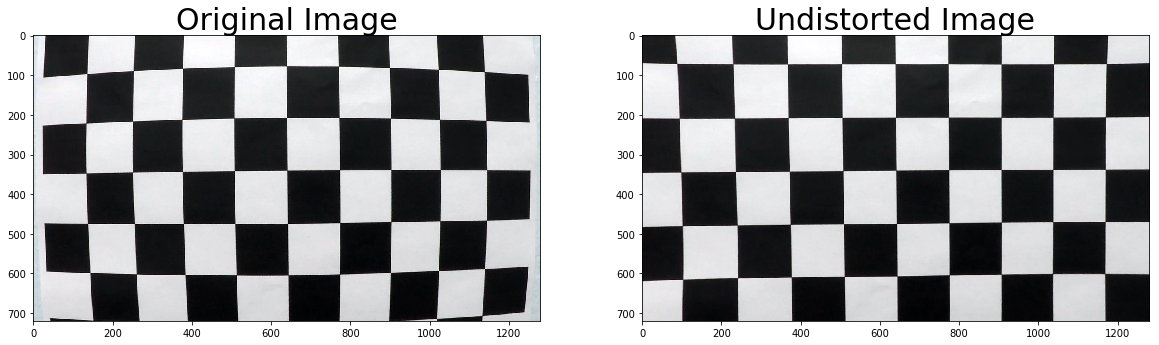

In [3]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('writeup_images/1.jpg', bbox_inches='tight') 
plt.show()

### Load the saved camera calibration data

In [4]:
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]


## Helper functions

In [5]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def U_channel(img):
    """Applies the U_channel transform
    This will return an image with only one color channel(U_channel in YUV)
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(U_img, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)[:,:,2]
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def cal_undistort(img, mtx, dist):
    # Use cv2.calibrateCamera() and cv2.undistort()
    undist=cv2.undistort(img,mtx,dist,None,mtx)
    return undist


def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    if orient=='x':
        sobel=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    else:
        sobel=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    sobel=np.absolute(sobel)
    sobel=np.uint8(255*sobel/np.max(sobel))
    binary_output=np.zeros_like(sobel)
    binary_output[(sobel>thresh[0])&(sobel<thresh[1])]=1
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    grad_mag=np.power((np.power(sobelx,2)+np.power(sobely,2)),.5)
    
    grad_abs=np.uint8(grad_mag*255/np.max(grad_mag))
    binary_output=np.zeros_like(gray)
    
    binary_output[(grad_abs>=mag_thresh[0])&(grad_abs<=mag_thresh[1])]=1
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sobelx=np.absolute(cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel))
    sobely=np.absolute(cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel))
    grad_dir=np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    #grad_dir=np.arctan(np.divide(sobely,sobelx))
    binary_output=np.zeros_like(grad_dir)
    
    binary_output[(grad_dir>=thresh[0])&(grad_dir<=thresh[1])]=1
    return binary_output



#lane finding


def get_lanes(binary_warped):
    global left_fit
    global right_fit
    global prev_left
    global prev_right
    global prev_prev_right
    global prev_prev_left
    global first_time

    if left_fit==None:
        #first_once
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        if (lefty.size!=0)&(leftx.size!=0):
            left_fit = np.polyfit(lefty, leftx, 2)
        else:
            left_fit=prev_left
        if (righty.size!=0)&(rightx.size!=0):
            right_fit = np.polyfit(righty, rightx, 2)
        else:
            right_fit=prev_right
        if first_time==1:
            first_time=0
            prev_left=left_fit
            prev_right=right_fit
            prev_prev_right=right_fit
            prev_prev_left=left_fit
    else:
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        if (lefty.size!=0)&(leftx.size!=0):
            left_fit = np.polyfit(lefty, leftx, 2)
        else:
            left_fit=prev_left
        if (righty.size!=0)&(rightx.size!=0):
            right_fit = np.polyfit(righty, rightx, 2)
        else:
            right_fit=prev_right
    left_fit= (left_fit+prev_left+prev_prev_left)/3
    right_fit=(right_fit+prev_right+prev_prev_right)/3
    prev_prev_right=prev_right
    prev_right=right_fit
    prev_prev_left=prev_left
    prev_left=left_fit
    return True

#generate binary image from original image
def generate_binary(image, plot=False):

    # create a CLAHE object for adaptive e1ualization.
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,1))

    #get the U_img
    U_img=U_channel(image)

    #inverse of the U_image
    U_image=255-U_img 
    U_img=clahe.apply(U_image)

    #get the gray_img
    gray_img=grayscale(image)
    g_img=clahe.apply(gray_img)

    
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(20,150))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

    # Threshold U channel
    u_thresh=(180, 256)
    u_binary = np.zeros_like(U_img)
    u_binary[(U_img >= u_thresh[0]) & (U_img <= u_thresh[1])] = 1

    # Threshold gray channel
    g_thresh=(245, 256)
    g_binary = np.zeros_like(g_img)
    g_binary[(g_img >= g_thresh[0]) & (g_img <= g_thresh[1])] = 1

    #combining gradient results
    combined_grad = np.zeros_like(dir_binary)
    combined_grad[((gradx == 1)  | ((mag_binary == 1) & (dir_binary == 1))) & ((g_img >= 180)|(U_img >=160))] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(g_binary)
    combined_binary[(combined_grad == 1)|(g_binary == 1)|(u_binary == 1) ] = 1

    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((combined_grad, g_binary,  u_binary))

    #plotting
    if plot==True:

        # Plotting U images
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('inverse of YUV-(U)-channel')
        ax1.imshow(U_image, cmap='gray')

        ax2.set_title('inverse of YUV-(U)-channel after adaptive quantization')
        ax2.imshow(U_img, cmap='gray')
        plt.savefig('writeup_images/3.jpg', bbox_inches='tight') 
        plt.show()

        # Plotting gray images
        plt.figure()
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('gray image')
        ax1.imshow(gray_img, cmap='gray')

        ax2.set_title('gray image after adaptive quantization')
        ax2.imshow(g_img, cmap='gray')
        plt.savefig('writeup_images/4.jpg', bbox_inches='tight') 
        plt.show()

        #plot U binary
        plt.figure()
        plt.title('YUV (U) channel threshold')
        plt.imshow(u_binary*255, cmap='gray')
        plt.savefig('writeup_images/5.jpg', bbox_inches='tight') 

        #plot gray binary
        plt.figure()
        plt.title('gray image threshold')
        plt.imshow(g_binary*255, cmap='gray')
        plt.savefig('writeup_images/6.jpg', bbox_inches='tight') 

        #plot gradient binary
        plt.figure()
        plt.title('edges')
        plt.imshow(combined_grad*255, cmap='gray')
        plt.savefig('writeup_images/7.jpg', bbox_inches='tight') 

        #plot binary channels
        plt.figure(figsize=(7.2*2,12.8*2))
        plt.title('Red:edges    Green:gray     Blue:U_channel')
        plt.imshow(color_binary)
        plt.savefig('writeup_images/8.jpg', bbox_inches='tight') 
        plt.show()

    return combined_binary

# Read an image

In [6]:
image=cv2.imread('test_images/straight_lines1.jpg')

# Undistort the image by camera matrix

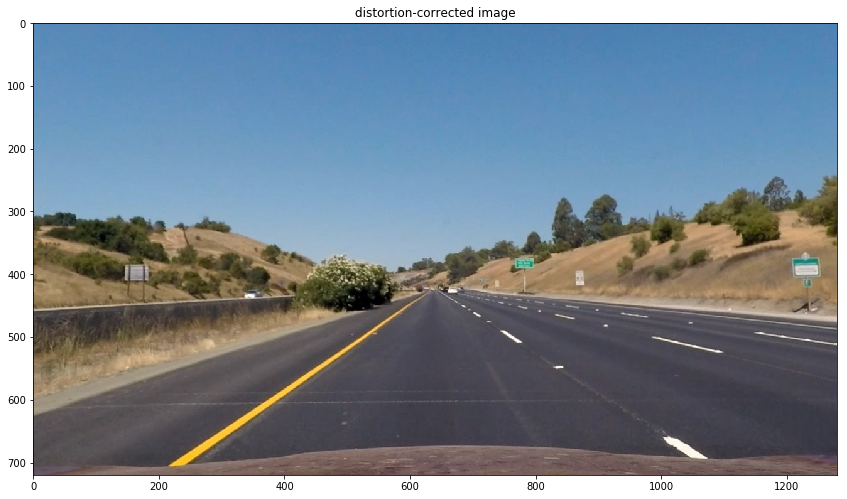

In [7]:
#undistort
image = cal_undistort(image, mtx, dist)
cv2.imwrite('writeup_images/2.jpg',image)
plt.figure(figsize=(7.2*2,12.8*2))
plt.title('distortion-corrected image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

# Generate binary image
### generate binary image from 3 channels
* YUV-(U)- channel
* gray channel
* gradient channel oring with the last 2 channels

### for the first 2 channels I used adaptive equalization to make the algorithm more reliable on lightness changes

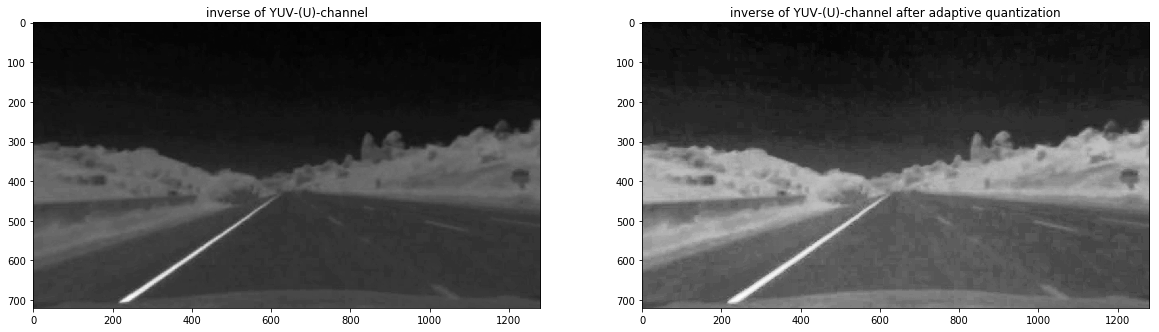

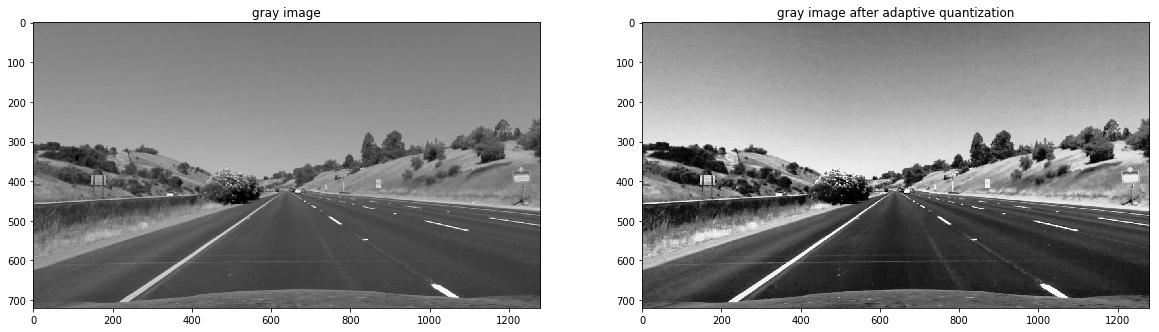

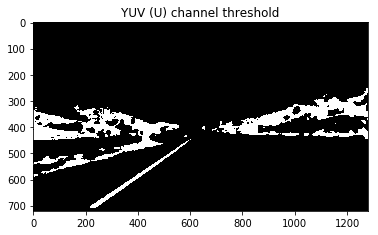

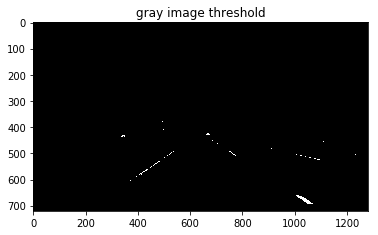

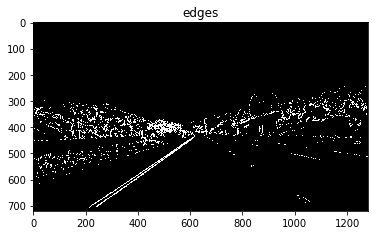

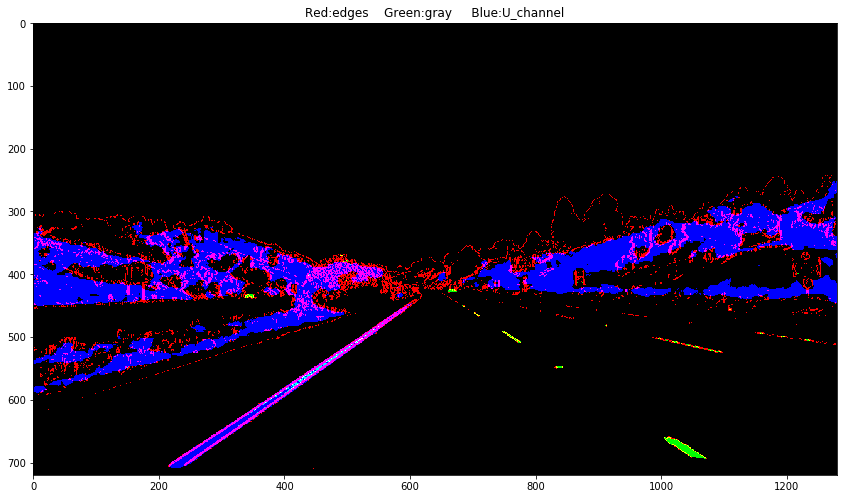

In [8]:
#generate binary image
combined_binary=generate_binary(image, plot=True)

# Perspective transform

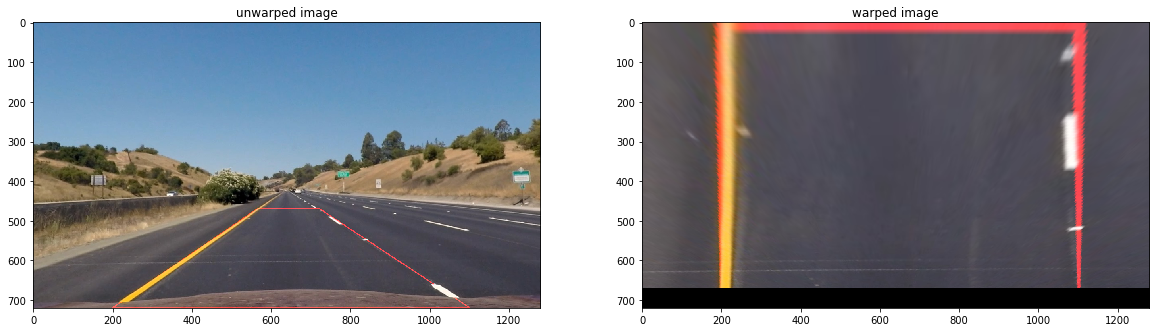

In [9]:
#drawing polygon
pts = np.array([[200,image.shape[0]-1],[565,470],[722,470],[1100,image.shape[0]-1]], np.int32)
pts = pts.reshape((-1,1,2))
img=np.zeros_like(image)
img = cv2.polylines(img,[pts],True,(0,0,255),2)
result=cv2.addWeighted(image, 1, img, 1, 0)

#unwrap
src=np.float32(
    [[200,image.shape[0]-1],
    [565,470],
    [722,470],
    [1100,image.shape[0]-1]
        ])
dst=np.float32(
    [[200,image.shape[0]-1],
    [200,0],
    [1100,0],
    [1100,image.shape[0]-1]
        ])
M=cv2.getPerspectiveTransform(src,dst)
Minv=cv2.getPerspectiveTransform(dst,src)
img_size=(image.shape[1],image.shape[0])
binary_warped=cv2.warpPerspective(result,M,img_size, flags=cv2.INTER_LINEAR)
binary_warped[image.shape[0]-50:,:]=0

# Plotting prespective images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('unwarped image')
ax1.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

ax2.set_title('warped image')
ax2.imshow(cv2.cvtColor(binary_warped, cv2.COLOR_BGR2RGB))
plt.savefig('writeup_images/9.jpg', bbox_inches='tight') 
plt.show()


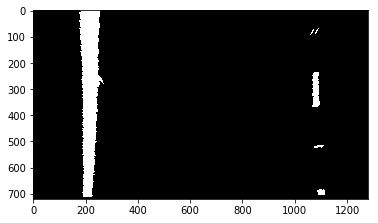

In [10]:
binary_warped=cv2.warpPerspective(combined_binary,M,img_size, flags=cv2.INTER_LINEAR)
plt.figure
plt.imshow(binary_warped,cmap='gray')
plt.show()

# Lane finding
### by curve fitting to the lane lines with 2nd degree polynomial function

In [11]:
#lane_finding
left_fit=None
right_fit=None
get_lanes(binary_warped)
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  


# Draw the lanes on the wraped image

In [12]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

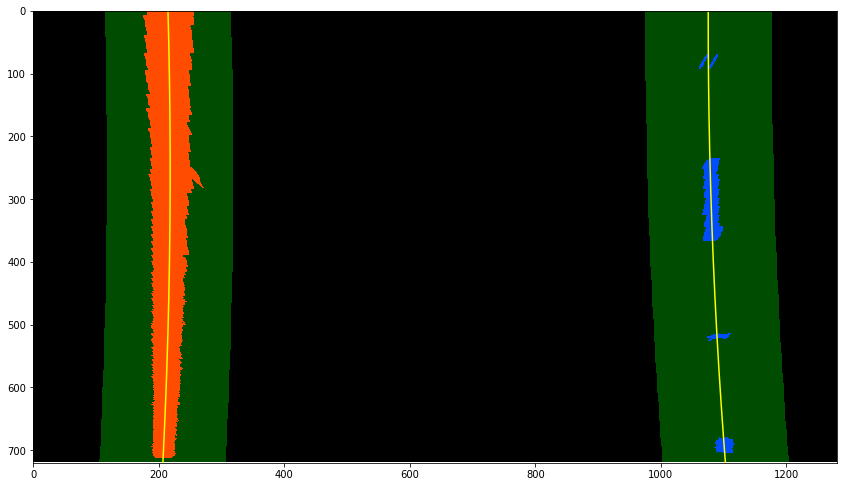

In [13]:
#Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.figure(figsize=(7.2*2,12.8*2))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('writeup_images/10.jpg', bbox_inches='tight') 
plt.show()

# Unwrap the detected lanes and put them in the original image

In [14]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(cv2.cvtColor(image,cv2.COLOR_BGR2RGB), 1, newwarp, 0.3, 0)


# Calculate the lane curvature and the distance from the center of the lane
### with putting in considration the pixel-meter transformation 

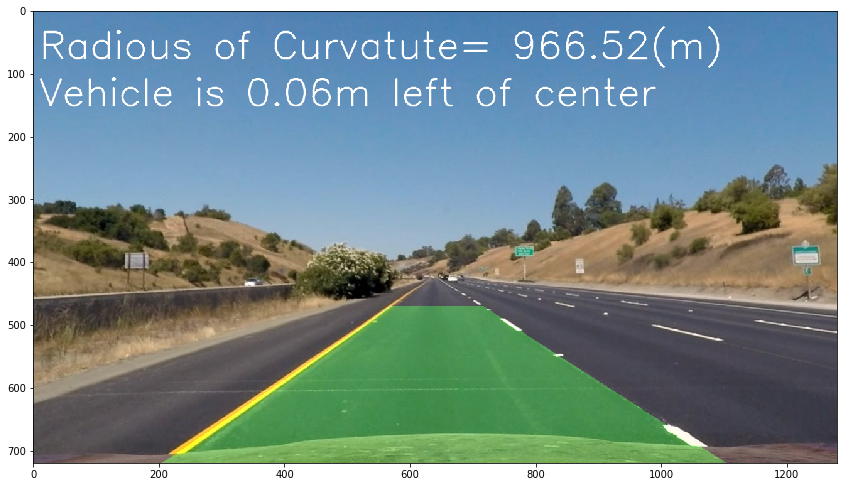

In [15]:
#curvature
# Define conversions in x and y from pixels space to meters
ym_per_pix = 15/720 # meters per pixel in y dimension
xm_per_pix = 3.7/900 # meters per pixel in x dimension
y_eval=image.shape[0]-1

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

if (abs(left_curverad-right_curverad)>400)|(left_curverad==right_curverad):
    left_fit=None
    right_fit=None

#calculate the distance from center and direction 
distance_px=(float(np.max(np.where(newwarp[-1,:,1]==255))+np.min(np.where(newwarp[-1,:,1]==255)))/2)-(image.shape[1]/2)
distance=distance_px * xm_per_pix
if distance>0:
    direction='left'
elif distance<0:
    direction='right'
else:
    direction='center'

#cv2.imwrite('hard2/'+str(image[100][100])+'.jpg',combined_grad*255)
#cv2.imwrite('hard1/'+str(image[100][100])+'.jpg',color_binary*255)
#put curvature on image
font = cv2.FONT_HERSHEY_SIMPLEX
result=cv2.putText(result,'Radious of Curvatute= {:.2f}(m)'.format((left_curverad+right_curverad)/2),(10,75), font, 2,(255,255,255),2,cv2.LINE_AA)
result=cv2.putText(result,'Vehicle is {:.2f}m '.format(abs(distance))+direction+' of center',(10,150), font, 2,(255,255,255),2,cv2.LINE_AA)

plt.figure(figsize=(7.2*2,12.8*2))
plt.imshow(result)
plt.savefig('writeup_images/11.jpg', bbox_inches='tight') 
plt.show()

In [16]:
#frame process
def frame_process(img):
    global left_fit
    global right_fit
    global mtx
    global dist
    global left_curverad 
    global right_curverad
  

    #undistort
    img = cal_undistort(img, mtx, dist)
    image=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    combined_binary=generate_binary(image)
    
    #50,(470,500),(470,730),1050
    #unwrap
    src=np.float32(
        [[200,image.shape[0]-1],
        [565,470],
        [722,470],
        [1100,image.shape[0]-1]
            ])
    dst=np.float32(
        [[200,image.shape[0]-1],
        [200,0],
        [1100,0],
        [1100,image.shape[0]-1]
            ])
    M=cv2.getPerspectiveTransform(src,dst)
    Minv=cv2.getPerspectiveTransform(dst,src)
    img_size=(image.shape[1],image.shape[0])
    binary_warped=cv2.warpPerspective(combined_binary,M,img_size, flags=cv2.INTER_LINEAR)
    binary_warped[image.shape[0]-50:,:]=0

    #lane_finding
    get_lanes(binary_warped)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    #result=cv2.cvtColor(result,cv2.COLOR_BGR2RGB)
    
    #curvature
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 15/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meters per pixel in x dimension
    y_eval=image.shape[0]-1
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    if (abs(left_curverad-right_curverad)>400)|(left_curverad==right_curverad):
        left_fit=None
        right_fit=None
     
    #calculate the distance from center and direction 
    distance_px=(float(np.max(np.where(newwarp[-1,:,1]==255))+np.min(np.where(newwarp[-1,:,1]==255)))/2)-(image.shape[1]/2)
    distance=distance_px * xm_per_pix
    if distance>0:
        direction='left'
    elif distance<0:
        direction='right'
    else:
        direction='center'
        
    #cv2.imwrite('hard2/'+str(image[100][100])+'.jpg',combined_grad*255)
    #cv2.imwrite('hard1/'+str(image[100][100])+'.jpg',color_binary*255)
    #put curvature on image
    font = cv2.FONT_HERSHEY_SIMPLEX
    result=cv2.putText(result,'Radious of Curvatute= {:.2f}(m)'.format((left_curverad+right_curverad)/2),(10,75), font, 2,(255,255,255),2,cv2.LINE_AA)
    result=cv2.putText(result,'Vehicle is {:.2f}m '.format(abs(distance))+direction+' of center',(10,150), font, 2,(255,255,255),2,cv2.LINE_AA)
    return result

In [17]:
#loading examples
import os
images_path=os.listdir("test_images/")

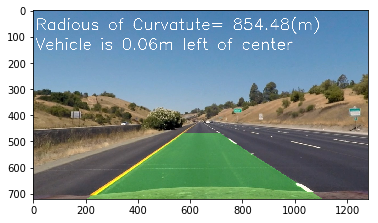

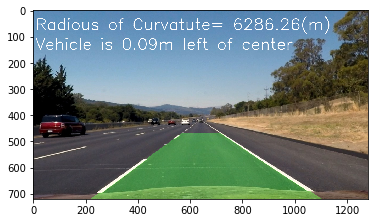

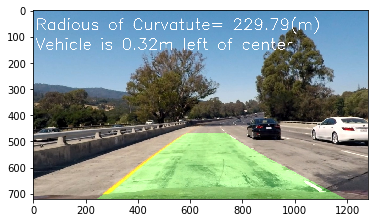

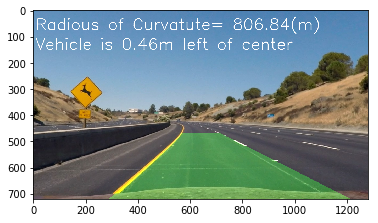

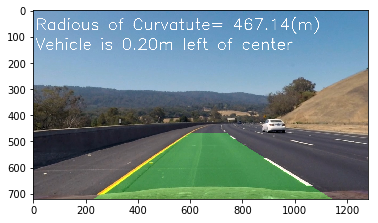

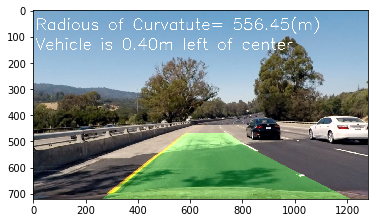

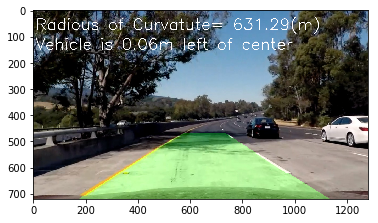

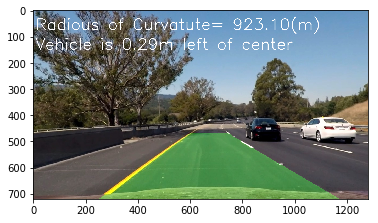

In [18]:
for image_path in images_path:
    left_fit=None
    right_fit=None
    first_time=1
    image= mpimg.imread('test_images/'+image_path)
    draw_img= frame_process(image)
    plt.figure()
    plt.imshow(draw_img)
    plt.show()
    cv2.imwrite('output_images/'+image_path,cv2.cvtColor(draw_img,cv2.COLOR_RGB2BGR))

In [19]:
left_fit=None
right_fit=None
first_time=1

white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(frame_process) #NOTE: this function expects color images!!
get_ipython().magic('time white_clip.write_videofile(white_output, audio=False)')



[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [10:12<00:00,  2.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 10min 14s


In [20]:
left_fit=None
right_fit=None
first_time=1

white_output = 'challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(frame_process) #NOTE: this function expects color images!!
get_ipython().magic('time white_clip.write_videofile(white_output, audio=False)')



[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [03:43<00:00,  2.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 3min 45s
